<a href="https://colab.research.google.com/github/murphyslaw2781/DATA---Data_Analysis/blob/main/electric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Google

## CSV Files

In [108]:
"""
Mount Google Drive, to Access your files. 
You will see a drive folder, and can navigate into MyDrive.
"""
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Nest Thermostat

In [ ]:
"""
Here you can connect to your Nest Thermostat if you need data to analyze


"""



### Example for making Nest API calls

Please start by making a copy of this notebook.

### Enter your credentials
Enter your credentials and run the cell to generate a login URL. Click the URL and log in to your Google account.

In [ ]:
project_id = 'your-project-id'
client_id = 'your-client-id.apps.googleusercontent.com'
client_secret = 'your-client-secret'
redirect_uri = 'https://www.google.com'

url = 'https://nestservices.google.com/partnerconnections/'+project_id+'/auth?redirect_uri='+redirect_uri+'&access_type=offline&prompt=consent&client_id='+client_id+'&response_type=code&scope=https://www.googleapis.com/auth/sdm.service'
print("Go to this URL to log in:")
print(url)

After logging in you are sent to URL you specified as redirect_url. Google added a query to end that looks like this: ?code=.....&scope=...
Copy the part between code= and &scope= and add it below:

In [ ]:
code = '4/add-your-code-here'

### Get tokens
Now we can use this code to retrieve an access token and a refresh token:

In [ ]:
# Get tokens

import requests

params = (
    ('client_id', client_id),
    ('client_secret', client_secret),
    ('code', code),
    ('grant_type', 'authorization_code'),
    ('redirect_uri', redirect_uri),
)

response = requests.post('https://www.googleapis.com/oauth2/v4/token', params=params)

response_json = response.json()
access_token = response_json['token_type'] + ' ' + str(response_json['access_token'])
print('Access token: ' + access_token)
refresh_token = response_json['refresh_token']
print('Refresh token: ' + refresh_token)

### Refresh access token
The access token is only valid for 60 minutes. You can use the refresh token to renew it.

In [ ]:
# Refresh token

params = (
    ('client_id', client_id),
    ('client_secret', client_secret),
    ('refresh_token', refresh_token),
    ('grant_type', 'refresh_token'),
)

response = requests.post('https://www.googleapis.com/oauth2/v4/token', params=params)

response_json = response.json()
access_token = response_json['token_type'] + ' ' + response_json['access_token']
print('Access token: ' + access_token)

### Get structures and devices
Now lets get some information about what devices we have access to and where these are "located". Devices are part of a structure (such as your home). We can get information about the structures we have access to:

In [ ]:
# Get structures

url_structures = 'https://smartdevicemanagement.googleapis.com/v1/enterprises/' + project_id + '/structures'

headers = {
    'Content-Type': 'application/json',
    'Authorization': access_token,
}

response = requests.get(url_structures, headers=headers)

print(response.json())

But we can also directly retrieve the devices we have access to:

In [ ]:
# Get devices

url_get_devices = 'https://smartdevicemanagement.googleapis.com/v1/enterprises/' + project_id + '/devices'

headers = {
    'Content-Type': 'application/json',
    'Authorization': access_token,
}

response = requests.get(url_get_devices, headers=headers)

print(response.json())

response_json = response.json()
device_0_name = response_json['devices'][0]['name']
print(device_0_name)

### Get device stats
For this example I simply took the first item of the array of devices. I assume most people probably have one Nest thermostat anyway.

The name of a device can be used to retrieve data from this device and to send commands to it. Lets get soms stats first:

In [ ]:
# Get device stats

url_get_device = 'https://smartdevicemanagement.googleapis.com/v1/' + device_0_name

headers = {
    'Content-Type': 'application/json',
    'Authorization': access_token,
}

response = requests.get(url_get_device, headers=headers)

response_json = response.json()
humidity = response_json['traits']['sdm.devices.traits.Humidity']['ambientHumidityPercent']
print('Humidity:', humidity)
temperature = response_json['traits']['sdm.devices.traits.Temperature']['ambientTemperatureCelsius']
print('Temperature:', temperature)

### Set thermostat to HEAT
And last but not least, lets send some commands to our thermostat. The cell below contains the code to set the mode to "HEAT":

In [ ]:
# Set mode to "HEAT"

url_set_mode = 'https://smartdevicemanagement.googleapis.com/v1/' + device_0_name + ':executeCommand'

headers = {
    'Content-Type': 'application/json',
    'Authorization': access_token,
}

data = '{ "command" : "sdm.devices.commands.ThermostatMode.SetMode", "params" : { "mode" : "HEAT" } }'

response = requests.post(url_set_mode, headers=headers, data=data)

print(response.json())

### Set a new temperature
And finally we can set a temperature by executing this command:

In [ ]:
set_temp_to = 21.0

In [ ]:
# Set temperature to set_temp_to degrees

url_set_mode = 'https://smartdevicemanagement.googleapis.com/v1/' + device_0_name + ':executeCommand'

headers = {
    'Content-Type': 'application/json',
    'Authorization': access_token,
}

data = '{"command" : "sdm.devices.commands.ThermostatTemperatureSetpoint.SetHeat", "params" : {"heatCelsius" : ' + str(set_temp_to) + '} }'

response = requests.post(url_set_mode, headers=headers, data=data)

print(response.json())

# Collect Data

## Weather

Weather Scraper for Wunderground

In [ ]:
!pip install selenium
!apt-get update 
!apt install chromium-chromedriver

from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [69]:
def get_weather_report(year,month):
    # create a new Chrome browser instance
    browser = webdriver.Chrome()
    #change your year
    url = f"https://www.wunderground.com/history/monthly/us/tx/houston/KHOU/date/{year}-{i}"
    browser.get(url)

    # wait for the table to be loaded
    wait = WebDriverWait(browser, 120)
    table = wait.until(EC.presence_of_element_located((By.CLASS_NAME, "days")))

    # get the page source after the JS has been executed
    html = browser.page_source

    # parse the HTML with Beautiful Soup
    soup = BeautifulSoup(html, "html.parser")

    # find the table you're interested in
    table = soup.find("table", {"class": "days"})
    # extract the column headers from the first row of the table
    column_headers = list(table.select('tr')[0].select('th, td'))
    column_headers = [th.text.strip() for th in column_headers]

    data_frames = []
    for row in table.select('tr'):
        for cell in row.select('td'):
            inner_table = cell.find('table')
            if inner_table:
                # Extract the data from the table
                data = []
                headers = []
                for inner_row in inner_table.select('tr'):
                    cells = inner_row.select('td')
                    if not headers:
                        headers = [cell.text.strip() for cell in cells]
                    else:
                        data.append([cell.text.strip() for cell in cells])
                # Create a new DataFrame and append it to the list
                df = pd.DataFrame(data, columns=headers)
                data_frames.append(df)


    combined_df = pd.concat(data_frames, axis=1)
    new_month = month.datetime.strftime(new_month,'%m')
    combined_df.to_csv(f'{month}_2022_weather.csv', index=False)

## Emporia

Need to put together multiple months of sheets
Save your sheets to a folder in your drive so you can access.

In [70]:
import glob
import os

# Set the path to the weather folder
path = '/content/drive/MyDrive/Energy/2022/weather'

# Use glob to get a list of all CSV files in the folder
file_list = glob.glob(os.path.join(path, '*_weather.csv'))
data_frames = []
# Loop through each file and read it into a dataframe
for file_name in file_list:
    df = pd.read_csv(file_name)
    strings = os.path.splitext(os.path.basename(file_name))[0].split('_')
    # Do something with the dataframe, e.g. print the first few rows
    df['date'] = pd.to_datetime(df[strings[0]].apply(lambda x: f'{strings[0]}-{x}-2022'))
    df = df.drop(strings[0], axis=1)
    data_frames.append(df)

weather_df = pd.concat(data_frames, ignore_index=True)

weather_df.head()


,Max,Avg,Min,Max.1,Avg.1,Min.1,Max.2,Avg.2,Min.2,Max.3,Avg.3,Min.3,Max.4,Avg.4,Min.4,Total,date
0,67,65.3,63,64,61.2,59,93,86.6,78,17,9.2,0,30.1,30.1,30.0,0.02,2022-11-01
1,77,68.9,62,67,61.4,58,90,77.3,62,15,9.3,3,30.2,30.1,30.1,0.43,2022-11-02
2,85,76.1,72,73,70.7,66,97,84.3,55,17,9.6,5,30.1,30.0,29.9,0.00,2022-11-03
3,85,78.5,73,75,72.8,70,91,83.3,67,24,13.9,6,29.9,29.8,29.7,0.00,2022-11-04
4,75,65.6,60,61,53.1,46,90,66.4,38,25,8.3,3,30.0,29.9,29.8,0.22,2022-11-05


In [71]:
# create the multi-index labels
index = [('TempMax', 'Max'), ('TempAvg', 'Avg'), ('TempMin', 'Min'),
         ('Dew PointMax', 'Max'), ('Dew PointAvg', 'Avg'), ('Dew PointMin', 'Min'),
         ('HumidityMax', 'Max'), ('HumidityAvg', 'Avg'), ('HumidityMin', 'Min'),
         ('Wind SpeedMax', 'Max'), ('Wind SpeedAvg', 'Avg'), ('Wind SpeedMin', 'Min'),
         ('PressureMax', 'Max'), ('PressureAvg', 'Avg'), ('PressureMin', 'Min'),
         ('PrecipitationTotal', 'Total'),('Date','Date')]

# create a multi-index from the labels
columns = pd.MultiIndex.from_tuples(index)

weather_df.columns = columns
weather_df.columns = weather_df.columns.droplevel(level=1)

weather_df.head()


,TempMax,TempAvg,TempMin,Dew PointMax,Dew PointAvg,Dew PointMin,HumidityMax,HumidityAvg,HumidityMin,Wind SpeedMax,Wind SpeedAvg,Wind SpeedMin,PressureMax,PressureAvg,PressureMin,PrecipitationTotal,Date
0,67,65.3,63,64,61.2,59,93,86.6,78,17,9.2,0,30.1,30.1,30.0,0.02,2022-11-01
1,77,68.9,62,67,61.4,58,90,77.3,62,15,9.3,3,30.2,30.1,30.1,0.43,2022-11-02
2,85,76.1,72,73,70.7,66,97,84.3,55,17,9.6,5,30.1,30.0,29.9,0.00,2022-11-03
3,85,78.5,73,75,72.8,70,91,83.3,67,24,13.9,6,29.9,29.8,29.7,0.00,2022-11-04
4,75,65.6,60,61,53.1,46,90,66.4,38,25,8.3,3,30.0,29.9,29.8,0.22,2022-11-05


## Energy


### Mount Google Drive

In [73]:
df_day = pd.read_csv("/content/drive/MyDrive/Energy/2022/9CC924-TwinLane_Main-1DAY.csv")
df_day["Time Bucket (America/Chicago)"] = pd.to_datetime(df_day["Time Bucket (America/Chicago)"])
df_day = df_day.rename(columns={"Time Bucket (America/Chicago)":"Date"})
df_day.head()

,Date,TwinLane Main-Mains_B (kWhs),TwinLane Main-Mains_C (kWhs),TwinLane Main-Air Conditioner-AC Compressor CombinedData (kWhs),TwinLane Main-Air Conditioner-AC Compressor SingleLeg (kWhs),TwinLane Main-Furnace-Air Handler (kWhs),TwinLane Main-Pump-Septic/Bedroom (kWhs),TwinLane Main-Computer/Network-The Office (kWhs),TwinLane Main-Room/Multi-use Circuit-Patio (kWhs),TwinLane Main-Garage/Shop/Barn/Shed-Sub Panel (kWhs),TwinLane Main-Lights-Emporia (kWhs),TwinLane Main-Cooktop/Range/Oven/Stove-Stove/Garbage Disposal/Dish Washer (kWhs),TwinLane Main-Water Heater-Water Heater/Microwave/Fridge (kWhs),TwinLane Main-Clothes Washer-Wash/Dry/Fridge (kWhs),TwinLane Main-Room/Multi-use Circuit-Living Room (kWhs)
0,2022-07-17,24.8643,24.9415,23.9773,12.0269,0.0953,0.8049,0.4759,0.2895,0.0000,0.0000,0.0683,0.1296,0.2966,2.9435
1,2022-07-18,91.4981,104.6239,61.9485,31.0890,0.1987,2.5173,2.9692,0.9393,7.7577,0.0655,0.3470,1.0560,1.4613,14.9820
2,2022-07-19,77.2243,96.4674,68.9753,34.5958,0.1288,2.6217,1.9160,1.6400,42.3982,0.2056,0.0129,3.6581,1.7040,16.3255
3,2022-07-20,79.2592,94.7919,70.6483,35.4267,0.1303,2.9567,3.4452,3.5671,40.8589,0.1298,1.2999,3.8811,1.2885,13.3651
4,2022-07-21,67.1388,77.9144,63.3746,31.7722,0.1373,2.4999,3.1709,3.3747,30.4211,0.0000,0.1663,3.6693,1.4309,15.6799


In [74]:
df_reliant = pd.read_csv("/content/drive/MyDrive/Energy/2022/yearlyUsageData Reliant.csv")
df_reliant.head()

,MONTH,MONTH_USAGE (kWh),MONTH_COST ($),MONTH_AVG_TEMP_HI,MONTH_AVG_TEMP_LO (F)
0,Jan,1551.9,263.83,59,49
1,Feb,1581.2,267.41,59,47
2,Mar,1952.7,322.40,69,58
3,Apr,3225.2,515.30,78,69
4,May,4600.4,736.73,85,76


### Cleaning

In [75]:
# Replace missing values with zeros
df_day = df_day.fillna(0)

# Check for missing values
df_day.isna().sum()


Date                                                                                0
TwinLane Main-Mains_B (kWhs)                                                        0
TwinLane Main-Mains_C (kWhs)                                                        0
TwinLane Main-Air Conditioner-AC Compressor CombinedData (kWhs)                     0
TwinLane Main-Air Conditioner-AC Compressor SingleLeg (kWhs)                        0
TwinLane Main-Furnace-Air Handler (kWhs)                                            0
TwinLane Main-Pump-Septic/Bedroom (kWhs)                                            0
TwinLane Main-Computer/Network-The Office (kWhs)                                    0
TwinLane Main-Room/Multi-use Circuit-Patio (kWhs)                                   0
TwinLane Main-Garage/Shop/Barn/Shed-Sub Panel (kWhs)                                0
TwinLane Main-Lights-Emporia (kWhs)                                                 0
TwinLane Main-Cooktop/Range/Oven/Stove-Stove/Garbage D

### Renaming Columns

In [76]:
def rename_columns(df, separator="-", new_separator="_"):
    new_column_names = []
    for column_name in df.columns:

        # Split the column name by the separator
        parts = column_name.split(separator)

        if parts[0] == 'Date':
            new_column_name = parts[0] + separator.join(parts[2:])
        # Check if the first two parts are Mains_B (kWhs) or Mains_C (kWhs), and keep them in the new column name
        elif parts[1] == 'Mains_B (kWhs)' or parts[1] == 'Mains_C (kWhs)':
            new_column_name = parts[1] + separator.join(parts[2:])
        else:
            # Remove the first two parts
            parts = parts[2:]

            # Join the remaining parts with the new separator
            new_column_name = new_separator.join(parts)

        # Add the new column name to the list
        new_column_names.append(new_column_name)
    
    # Rename the columns using a dictionary comprehension
    df = df.rename(columns={old: new for old, new in zip(df.columns, new_column_names)})
    
    return df


df_day = rename_columns(df_day,separator="-", new_separator="_")

In [77]:
df_day.head()

,Date,Mains_B (kWhs),Mains_C (kWhs),AC Compressor CombinedData (kWhs),AC Compressor SingleLeg (kWhs),Air Handler (kWhs),Septic/Bedroom (kWhs),The Office (kWhs),use Circuit_Patio (kWhs),Sub Panel (kWhs),Emporia (kWhs),Stove/Garbage Disposal/Dish Washer (kWhs),Water Heater/Microwave/Fridge (kWhs),Wash/Dry/Fridge (kWhs),use Circuit_Living Room (kWhs)
0,2022-07-17,24.8643,24.9415,23.9773,12.0269,0.0953,0.8049,0.4759,0.2895,0.0000,0.0000,0.0683,0.1296,0.2966,2.9435
1,2022-07-18,91.4981,104.6239,61.9485,31.0890,0.1987,2.5173,2.9692,0.9393,7.7577,0.0655,0.3470,1.0560,1.4613,14.9820
2,2022-07-19,77.2243,96.4674,68.9753,34.5958,0.1288,2.6217,1.9160,1.6400,42.3982,0.2056,0.0129,3.6581,1.7040,16.3255
3,2022-07-20,79.2592,94.7919,70.6483,35.4267,0.1303,2.9567,3.4452,3.5671,40.8589,0.1298,1.2999,3.8811,1.2885,13.3651
4,2022-07-21,67.1388,77.9144,63.3746,31.7722,0.1373,2.4999,3.1709,3.3747,30.4211,0.0000,0.1663,3.6693,1.4309,15.6799


### Totals
After Readin up on Emporia Community, there are issues with the Mains not equaling the total usage.  In this case go with the Higher value. 

In [84]:
df_day['MainsAVG'] = df_day[['Mains_B (kWhs)', 'Mains_C (kWhs)']].sum(axis=1)
df_day['poolpump'] = 10.872
df_day['Sub Panel (kWhs)'] = df_day['Sub Panel (kWhs)'] - df_day['poolpump']
df_day['Legs_Total'] = df_day.select_dtypes(include=np.number).drop(['MainsAVG','Mains_B (kWhs)','Mains_C (kWhs)','AC Compressor SingleLeg (kWhs)','poolpump'],axis=1).sum(axis=1)

df_day[['MainsAVG','Legs_Total','poolpump']]
df_day['AC Total'] = df_day['AC Compressor CombinedData (kWhs)'] + df_day['AC Compressor SingleLeg (kWhs)']
df_day.head()


,Date,Mains_B (kWhs),Mains_C (kWhs),AC Compressor CombinedData (kWhs),AC Compressor SingleLeg (kWhs),Air Handler (kWhs),Septic/Bedroom (kWhs),The Office (kWhs),use Circuit_Patio (kWhs),Sub Panel (kWhs),Emporia (kWhs),Stove/Garbage Disposal/Dish Washer (kWhs),Water Heater/Microwave/Fridge (kWhs),Wash/Dry/Fridge (kWhs),use Circuit_Living Room (kWhs),MainsAVG,poolpump,Legs_Total,AC Total
0,2022-07-17,24.8643,24.9415,23.9773,12.0269,0.0953,0.8049,0.4759,0.2895,-21.7440,0.0000,0.0683,0.1296,0.2966,2.9435,49.8058,10.872,25.5458,36.0042
1,2022-07-18,91.4981,104.6239,61.9485,31.0890,0.1987,2.5173,2.9692,0.9393,-13.9863,0.0655,0.3470,1.0560,1.4613,14.9820,196.1220,10.872,155.8690,93.0375
2,2022-07-19,77.2243,96.4674,68.9753,34.5958,0.1288,2.6217,1.9160,1.6400,20.6542,0.2056,0.0129,3.6581,1.7040,16.3255,173.6917,10.872,246.5562,103.5711
3,2022-07-20,79.2592,94.7919,70.6483,35.4267,0.1303,2.9567,3.4452,3.5671,19.1149,0.1298,1.2999,3.8811,1.2885,13.3651,174.0511,10.872,250.5258,106.0750
4,2022-07-21,67.1388,77.9144,63.3746,31.7722,0.1373,2.4999,3.1709,3.3747,8.6771,0.0000,0.1663,3.6693,1.4309,15.6799,145.0532,10.872,215.2338,95.1468


In [79]:
df_monthly = df_day.groupby(df_day['Date'].dt.to_period('M')).agg({
    'MainsAVG': 'sum',
    'poolpump':'sum',
    'Sub Panel (kWhs)':'sum',
    'AC Compressor CombinedData (kWhs)':'sum'
})

df_monthly['Month'] = df_monthly.index.strftime('%b')

# Rename columns
new_columns = {
    'MainsAVG': 'Usage',
    'poolpump': 'PoolPump',
    'Sub Panel (kWhs)': 'SubPanel',
    'AC Compressor CombinedData (kWhs)': 'AC'
}

df_monthly = df_monthly.rename(columns=new_columns)

df_monthly

,Usage,PoolPump,SubPanel,AC,Month
Date,,,,,
2022-07,2469.4441,163.080,660.2524,850.3988,Jul
2022-08,4648.0009,337.032,1478.0873,1575.4292,Aug
2022-09,3867.6268,326.160,1146.9618,1197.3402,Sep
2022-10,2653.9652,337.032,841.3485,486.3807,Oct
2022-11,2204.0446,326.160,715.7613,283.4411,Nov
2022-12,2266.5914,337.032,696.9589,204.0963,Dec


In [80]:
df_merged = pd.merge(df_monthly, df_reliant, left_on='Month', right_on='MONTH')
df_merged = df_merged.rename(columns={'MONTH_USAGE (kWh)': 'Reliant Usage'})
df_merged

,Usage,PoolPump,SubPanel,AC,Month,MONTH,Reliant Usage,MONTH_COST ($),MONTH_AVG_TEMP_HI,MONTH_AVG_TEMP_LO (F)
0,2469.4441,163.080,660.2524,850.3988,Jul,Jul,5372.2,857.06,92,82
1,4648.0009,337.032,1478.0873,1575.4292,Aug,Aug,4655.9,739.17,88,81
2,3867.6268,326.160,1146.9618,1197.3402,Sep,Sep,3880.8,635.00,86,75
3,2653.9652,337.032,841.3485,486.3807,Oct,Oct,2662.9,455.02,77,66
4,2204.0446,326.160,715.7613,283.4411,Nov,Nov,2203.6,377.34,65,57
5,2266.5914,337.032,696.9589,204.0963,Dec,Dec,2261.8,387.89,62,53


Compare All the Sums

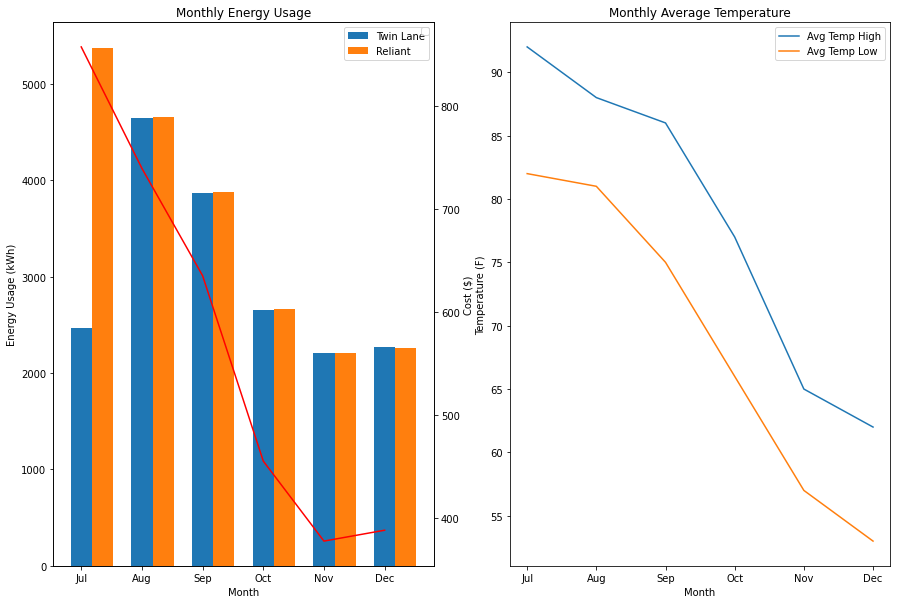

In [81]:
# Set figure size
plt.figure(figsize=(15, 10))

# Create bar chart for kWh
ax1 = plt.subplot(1, 2, 1)
kwh = np.array(df_merged[['Usage', 'Reliant Usage']])
bar_width = 0.35
ax1.bar(np.arange(len(df_merged['Month'])), kwh[:, 0], width=bar_width, label='Twin Lane')
ax1.bar(np.arange(len(df_merged['Month'])) + bar_width, kwh[:, 1], width=bar_width, label='Reliant')
ax1.set_xticks(np.arange(len(df_merged['Month'])) + bar_width/2)
ax1.set_xticklabels(df_merged['Month'])
ax1.set_xlabel('Month')
ax1.set_ylabel('Energy Usage (kWh)')
ax1.set_title('Monthly Energy Usage')
ax1.legend()

# Create bar chart for cost
ax2 = ax1.twinx()
cost = np.array(df_merged['MONTH_COST ($)'])
ax2.plot(df_merged['Month'], cost, color='r')
ax2.set_ylabel('Cost ($)')
ax2.legend()

# Create line chart for temperature
ax3 = plt.subplot(1, 2, 2)
temp = np.array(df_merged[['MONTH_AVG_TEMP_HI', 'MONTH_AVG_TEMP_LO (F)']])
ax3.plot(df_merged['Month'], temp[:, 0], label='Avg Temp High')
ax3.plot(df_merged['Month'], temp[:, 1], label='Avg Temp Low')
ax3.set_xlabel('Month')
ax3.set_ylabel('Temperature (F)')
ax3.set_title('Monthly Average Temperature')
ax3.legend()

plt.show()


# Analyze

## Daily

In [103]:
weather_energy_df = pd.merge(df_day, weather_df, on='Date')

# Select columns for AC usage, temperature, and humidity
energy_cols = ['AC Total','poolpump','Sub Panel (kWhs)','MainsAVG']
temp_cols = ['TempMax',	'TempAvg',	'TempMin']
humidity_cols = ['HumidityMax','HumidityAvg','HumidityMin']
#Add Dates
weather_energy_df['Month']=weather_energy_df['Date'].dt.month
weather_energy_df['Year']=weather_energy_df['Date'].dt.year
date_cols = ['Date','Month','Year']

# Create a new dataframe with the selected columns
ac_temp_humid_df =weather_energy_df[energy_cols + temp_cols + humidity_cols+date_cols]

# Print the correlation matrix
ac_temp_humid_df.head()

,AC Total,poolpump,Sub Panel (kWhs),MainsAVG,TempMax,TempAvg,TempMin,HumidityMax,HumidityAvg,HumidityMin,Date,Month,Year
0,36.0042,10.872,-21.7440,49.8058,98,86.5,78,90,65.8,30,2022-07-17,7,2022
1,93.0375,10.872,-13.9863,196.1220,99,87.7,78,88,62.4,34,2022-07-18,7,2022
2,103.5711,10.872,20.6542,173.6917,98,87.8,80,87,64.5,41,2022-07-19,7,2022
3,106.0750,10.872,19.1149,174.0511,99,88.4,80,87,65.3,40,2022-07-20,7,2022
4,95.1468,10.872,8.6771,145.0532,98,87.3,79,90,66.4,39,2022-07-21,7,2022


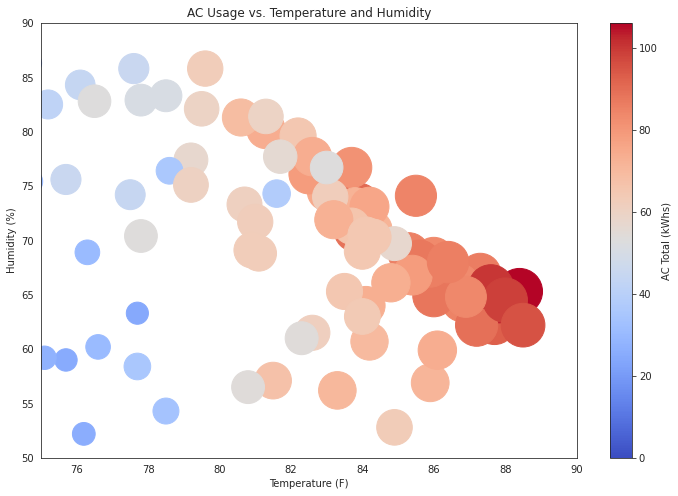

In [129]:
import matplotlib.pyplot as plt

# Plot AC usage over temperature and humidity
fig, ax = plt.subplots(figsize=(12, 8))
sc = ax.scatter(ac_temp_humid_df['TempAvg'], ac_temp_humid_df['HumidityAvg'], s=ac_temp_humid_df['AC Total']*20, c=ac_temp_humid_df['AC Total'], cmap='coolwarm')
ax.set_xlabel('Temperature (F)')
ax.set_ylabel('Humidity (%)')
ax.set_title('AC Usage vs. Temperature and Humidity')
ax.set_xlim(75, 90)
ax.set_ylim(50,90)

# Add colorbar
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('AC Total (kWhs)')

plt.show()


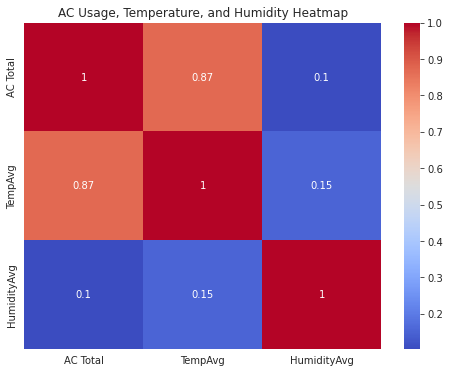

In [117]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(ac_temp_humid_df[['AC Total', 'TempAvg', 'HumidityAvg']].corr(), annot=True, cmap='coolwarm', ax=ax)
plt.title('AC Usage, Temperature, and Humidity Heatmap')
plt.show()

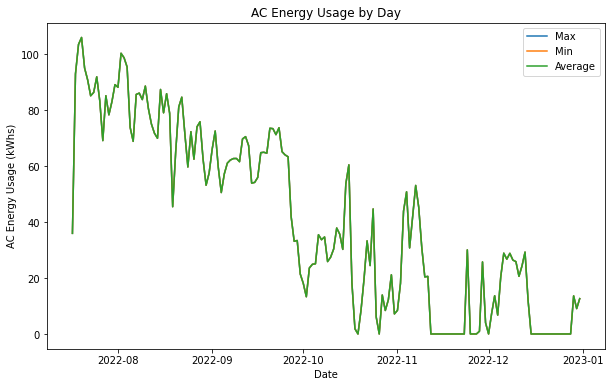

In [114]:
import matplotlib.pyplot as plt

# Group the data by date to get the total AC usage per day
ac_daily = ac_temp_humid_df.groupby('Date')['AC Total'].sum()

# Get the max, min, and average AC usage per day
ac_daily_max = ac_temp_humid_df.groupby('Date')['AC Total'].max()
ac_daily_min = ac_temp_humid_df.groupby('Date')['AC Total'].min()
ac_daily_avg = ac_temp_humid_df.groupby('Date')['AC Total'].mean()

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the max, min, and average AC usage per day
ax.plot(ac_daily_max, label='Max')
ax.plot(ac_daily_min, label='Min')
ax.plot(ac_daily_avg, label='Average')

# Set the x-axis label, y-axis label, and title
ax.set_xlabel('Date')
ax.set_ylabel('AC Energy Usage (kWhs)')
ax.set_title('AC Energy Usage by Day')

# Add a legend
ax.legend()

# Display the plot
plt.show()


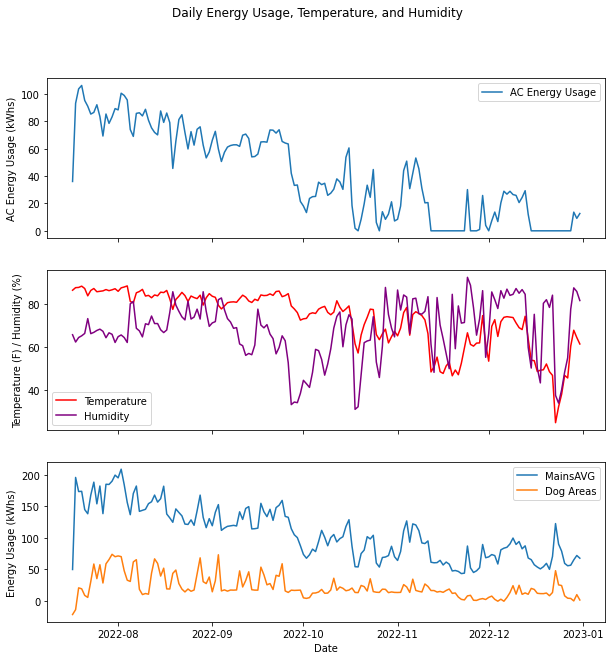

In [107]:
# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# Plot daily AC energy usage over time
ax1.plot(ac_temp_humid_df['Date'], ac_temp_humid_df['AC Total'], label='AC Energy Usage')
ax1.set_ylabel('AC Energy Usage (kWhs)')
ax1.legend()

# Plot daily average temperature and humidity over time
ax2.plot(ac_temp_humid_df['Date'], ac_temp_humid_df['TempAvg'],color = 'red', label='Temperature')
ax2.plot(ac_temp_humid_df['Date'], ac_temp_humid_df['HumidityAvg'],color='purple', label='Humidity')
ax2.set_ylabel('Temperature (F) / Humidity (%)')
ax2.legend()

# Plot daily MainsAVG and Subpanel energy usage over time
ax3.plot(ac_temp_humid_df['Date'], ac_temp_humid_df['MainsAVG'], label='MainsAVG')
ax3.plot(ac_temp_humid_df['Date'], ac_temp_humid_df['Sub Panel (kWhs)'], label='Dog Areas')
ax3.set_ylabel('Energy Usage (kWhs)')
ax3.legend()

# Add a title and axis label to the bottom subplot
ax3.set_xlabel('Date')
fig.suptitle('Daily Energy Usage, Temperature, and Humidity')

plt.show()



## Monthly

In [100]:
monthly_totals = ac_temp_humid_df.groupby(['Year', 'Month']).sum()

# calculate the average temperature and humidity for each month
monthly_averages = ac_temp_humid_df.groupby(['Year', 'Month'])[['TempAvg', 'HumidityAvg']].mean()

# merge the monthly totals and monthly averages into a single dataframe
monthly_data = pd.merge(monthly_totals, monthly_averages, on=['Year', 'Month'])

monthly_data

AC Total  poolpump  Sub Panel (kWhs)  TempMax  TempAvg_x  \
Year Month                                                              
2022 7      1276.8954   163.080          497.1724     1439     1300.3   
     8      2365.8970   337.032         1141.0553     2877     2604.6   
     9      1798.2162   326.160          820.8018     2740     2454.9   
     10      730.7323   337.032          504.3165     2559     2243.9   
     11      425.7010   326.160          389.6013     2087     1855.0   
     12      306.6162   337.032          359.9269     2100     1820.8   

            TempMin  HumidityMax  HumidityAvg_x  HumidityMin  TempAvg_y  \
Year Month                                                                
2022 7         1184         1314          993.8          623  86.686667   
     8         2411         2770         2257.3         1556  84.019355   
     9         2220         2467         1877.5         1159  81.830000   
     10        1958         2493         1835.0         1095  72.383871   
     11        1610         2679         2214.2         1558  61.833333   
     12        1568         2713         2233.2         1522  58.735484   

            HumidityAvg_y  
Year Month                 
2022 7          66.253333  
     8          72.816129  
     9          62.583333  
     10         59.193548  
     11         73.806667  
     12         72.038710